In [1]:
import json
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm

from analysis_utils import get_test_results_all_tasks, target_testsuites, get_test_results

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
import torch
import random

import time
import gc

from analysis_utils import load_input_hidden_states
import scienceplots

plt.style.use(["science", "grid", "nature"])

plt.rcParams.update({
    "font.size": 12,           
    "axes.titlesize": 14,      
    "axes.labelsize": 12,      
    "xtick.labelsize": 10,     
    "ytick.labelsize": 10,     
    "legend.fontsize": 10,     
})

tasks = list(target_testsuites.keys())
print('Prompting Tasks:', tasks)

model = 'llama'
inference_results, labels, test_scores = get_test_results_all_tasks(model)

Prompting Tasks: ['syntactic_bug_detection', 'spell_check', 'github_typo_check', 'json_repair', 'pos_detection', 'topic_classification', 'adding_odd_numbers', 'model_name_extraction']


Processing datasets: 100%|██████████| 8/8 [00:14<00:00,  1.84s/it]


### A. Task-specific subspace of internal hidden states (Exploratory Study 2.1)

In [2]:
target_layer = 16

hidden_vectors_all_tasks = None
tasks_list = []
test_scores_list = []

for task in tqdm(tasks, desc='Loading input hidden states...'):
    hidden_states = load_input_hidden_states(task, target_layer)
    print(hidden_states.shape)
    if hidden_vectors_all_tasks is None:
        hidden_vectors_all_tasks = hidden_states
    else:
        hidden_vectors_all_tasks = np.concatenate((hidden_vectors_all_tasks, hidden_states), axis=0)
    tasks_list.extend([task] * hidden_states.shape[0])
    test_scores_list.extend(test_scores[task])

start_time = time.time()
pca = PCA(n_components=10)
data_pca = pca.fit_transform(hidden_vectors_all_tasks)
print('* * * Done PCA Transformation (elapsed time: {})'.format(time.time() - start_time))

tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_pca)
print('* * * Done t-SNE Transformation (elapsed time: {})'.format(time.time() - start_time))

del tsne, data_pca
gc.collect()

df_vis = pd.DataFrame(data_tsne, columns=["Component 1", "Component 2"])
df_vis["Task"] = tasks_list
df_vis["Test Score"] = test_scores_list

Loading input hidden states...:  12%|█▎        | 1/8 [00:01<00:13,  1.88s/it]

torch.Size([20518, 4096])
torch.Size([10000, 4096])


Loading input hidden states...:  25%|██▌       | 2/8 [00:04<00:15,  2.57s/it]

torch.Size([10000, 4096])


Loading input hidden states...:  38%|███▊      | 3/8 [00:09<00:17,  3.45s/it]

torch.Size([6563, 4096])


Loading input hidden states...:  50%|█████     | 4/8 [00:14<00:15,  3.96s/it]

torch.Size([15359, 4096])


Loading input hidden states...:  62%|██████▎   | 5/8 [00:17<00:11,  3.84s/it]

torch.Size([7600, 4096])


Loading input hidden states...:  75%|███████▌  | 6/8 [00:21<00:07,  3.94s/it]

torch.Size([6000, 4096])


Loading input hidden states...:  88%|████████▊ | 7/8 [00:25<00:03,  3.91s/it]

torch.Size([9810, 4096])


Loading input hidden states...: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]


* * * Done PCA Transformation (elapsed time: 4.286216735839844)
* * * Done t-SNE Transformation (elapsed time: 151.93284630775452)


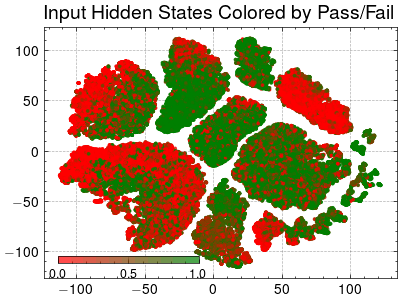

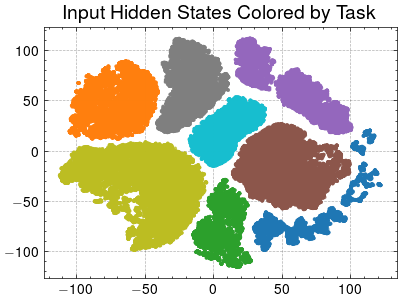

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig_1, ax_1 = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True)
fig_2, ax_2 = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True)

cmap = LinearSegmentedColormap.from_list("red_green", ["red", "green"], N=11)
scatter_1 = ax_1.scatter(df_vis["Component 1"], df_vis["Component 2"], c=df_vis["Test Score"], cmap=cmap, alpha=0.7, s=3)
ax_1.grid(alpha=0.3)

cax0 = inset_axes(
    ax_1, width="40%", height="3%", loc="lower left",
    bbox_to_anchor=(0.04, 0.06, 1, 1),  # (x0, y0, w, h) in axes coords
    bbox_transform=ax_1.transAxes, borderpad=0
)
cb0 = fig_1.colorbar(scatter_1, cax=cax0, orientation='horizontal')
cax0.set_zorder(10)
cax0.tick_params(labelsize=9)

tasks = df_vis["Task"].astype("category")
codes = tasks.cat.codes
cmap_tasks = plt.get_cmap("tab10")

scatter_2 = ax_2.scatter(df_vis["Component 1"], df_vis["Component 2"], c=codes, cmap=cmap_tasks, alpha=0.7, s=3)
ax_2.grid(alpha=0.3)

handles, _ = scatter_2.legend_elements(prop="colors", num=len(tasks.cat.categories))
ax_2.legend([], [], frameon=False)

ax_1.set_title('Input Hidden States Colored by Pass/Fail')
ax_2.set_title('Input Hidden States Colored by Task')

os.makedirs('figures/exploratory', exist_ok=True)
fig_1.savefig('figures/exploratory/all_task_tsne_pass_fail_llama_16.png')
fig_1.savefig('figures/exploratory/all_task_tsne_pass_fail_llama_16.pdf', dpi=300)
fig_2.savefig('figures/exploratory/all_task_tsne_task_cluster_llama_16.png')
fig_2.savefig('figures/exploratory/all_task_tsne_task_cluster_llama_16.pdf', dpi=300)

### B. Within vs. Cross-task Passing Input Space Transformation (Exploratory Study 2.1)

* * * Done PCA Transformation (elapsed time: 0.1560046672821045)


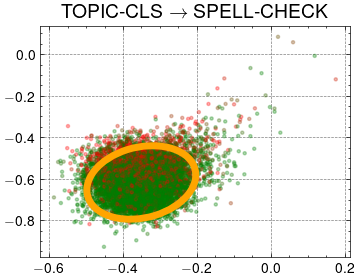

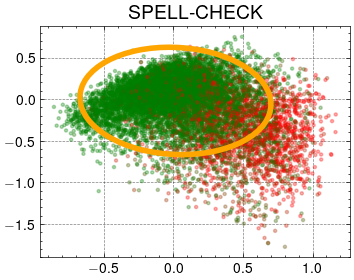

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from matplotlib.patches import Ellipse
from scipy.stats import chi2

from collections import defaultdict 

task_alias_map = {
    "syntactic_bug_detection": "SYN-BUG",
    "spell_check": "SPELL-CHECK",
    "github_typo_check": "GH-TYPO",
    "json_repair": "JSON-FIX",
    "pos_detection": "POS-TAG",
    "topic_classification": "TOPIC-CLS",
    "adding_odd_numbers": "ODD-ADD",
    "model_name_extraction": "MODEL-EX",
}

cmap = LinearSegmentedColormap.from_list("red_green", ["red", "green"], N=11)

reference_task = 'topic_classification'
test_task = 'spell_check'

target_layer = 16

reference_data = load_input_hidden_states(reference_task, target_layer)
test_data = load_input_hidden_states(test_task, target_layer)

_, _, scores_ref = get_test_results("llama", reference_task)
_, _, scores_test = get_test_results("llama", test_task)

random.seed(42)

passing_indices_ref = (np.asarray(scores_ref) > 0.5)
passing_indices_ref = random.sample(list(np.where(passing_indices_ref)[0]), k=300)
passing_indices_test_all = (np.asarray(scores_test) > 0.5)
passing_indices_test = random.sample(list(np.where(passing_indices_test_all)[0]), k=300)

fig_1, ax_1 = plt.subplots(1, 1, figsize=(4, 3))
fig_2, ax_2 = plt.subplots(1, 1, figsize=(4, 3))

start_time = time.time()
pca_ref_passing = PCA(n_components=2)
pca_ref_passing.fit(reference_data[passing_indices_ref])
data_pca_ref_passing = pca_ref_passing.transform(test_data)
print('* * * Done PCA Transformation (elapsed time: {})'.format(time.time() - start_time))


# 1. Cross-task projection on passing input space
target_pass_cross = data_pca_ref_passing[passing_indices_test_all]

mu = target_pass_cross.mean(axis=0)
cov = np.cov(target_pass_cross, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov)

chi2_val = chi2.ppf(0.90, df=2)
width, height = 2 * np.sqrt(eigvals * chi2_val)
angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

ax_1.scatter(data_pca_ref_passing[:,0], data_pca_ref_passing[:,1], alpha=0.3, cmap=cmap, c=np.array(scores_test), s=5)
ellipse = Ellipse(mu, width, height, angle=angle, edgecolor='orange', facecolor='none', lw=5)
ax_1.add_patch(ellipse)
ax_1.set_title("{} $\\rightarrow$ {}".format(task_alias_map[reference_task],task_alias_map[test_task]), fontsize=14)
ax_1.legend([], [], frameon=False)

start_time = time.time()
pca_test_passing = PCA(n_components=2)
pca_test_passing.fit(test_data[passing_indices_test])
data_pca_test_passing = pca_test_passing.transform(test_data)

# 1. Within-task projection on passing input space
target_pass_within = data_pca_test_passing[passing_indices_test_all]

mu = target_pass_within.mean(axis=0)
cov = np.cov(target_pass_within, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov)

chi2_val = chi2.ppf(0.90, df=2)
width, height = 2 * np.sqrt(eigvals * chi2_val)
angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

ax_2.scatter(data_pca_test_passing[:,0], data_pca_test_passing[:,1], alpha=0.3, cmap=cmap, c=np.array(scores_test), s=5)
ax_2.legend([], [], frameon=False)
ellipse = Ellipse(mu, width, height, angle=angle, edgecolor='orange', facecolor='none', lw=4)
ax_2.add_patch(ellipse)
ax_2.set_title("{}".format(task_alias_map[test_task]), fontsize=14)

fig_1.savefig('./figures/exploratory/OOD_{}_to_{}_cross_task_example_llama.png'.format(reference_task, test_task))
fig_1.savefig('./figures/exploratory/OOD_{}_to_{}_cross_task_example_llama.pdf'.format(reference_task, test_task), dpi=300)
fig_2.savefig('./figures/exploratory/OOD_{}_within_task_example_llama.png'.format(test_task))
fig_2.savefig('./figures/exploratory/OOD_{}_within_task_example_llama.pdf'.format(test_task), dpi=300)